In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [2]:
%load_ext autoreload
%autoreload 2

# Amazon-670K

> API details

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [4]:
from fastai.text.all import *
from fastai.distributed import *

from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path as the path of the repository

In [5]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path_model.mkdir(exist_ok=True)
path_data.mkdir(exist_ok=True)

file_prefix = 'amazon-670k'

data = path_data/(file_prefix+'.csv')
data_sample = path_data/(file_prefix+'-sample.csv')
dls_lm_path = path_model/f"{file_prefix}_dls_lm.pkl"
dls_lm_vocab_path = path_model/f"{file_prefix}_dls_lm_vocab.pkl"
lm_path = path_model/f"{file_prefix}_lm.pth"
lm_finetuned_path = path_model/f"{file_prefix}_lm_finetuned.pth"
dsets_clas_path = path_model/f"{file_prefix}_dset_clas.pkl"
dls_clas_path = path_model/f"{file_prefix}_dls_clas.pkl"
dls_clas_sample_path = path_model/f"{file_prefix}-sample_dls_clas.pkl"
clas_path = path_model/f"{file_prefix}_clas.pth"

print(f"{path = }")  
print(f"{path_data = }") 
print(f"{path_model = }") 
print(f"{file_prefix = }") 
print(f"{data = }")
print(f"{data_sample = }")  
print(f"{dls_lm_path = }") 
print(f"{dls_lm_vocab_path = }")
print(f"{lm_path = }")
print(f"{lm_finetuned_path = }")
print(f"{dsets_clas_path = }")
print(f"{dls_clas_path = }")
print(f"{dls_clas_sample_path = }")
print(f"{clas_path = }")

path = Path('/home/deb/xcube/nbs/examples/amazon-670k')
path_data = Path('/home/deb/xcube/nbs/examples/amazon-670k/data')
path_model = Path('/home/deb/xcube/nbs/examples/amazon-670k/models')
file_prefix = 'amazon-670k'
data = Path('/home/deb/xcube/nbs/examples/amazon-670k/data/amazon-670k.csv')
data_sample = Path('/home/deb/xcube/nbs/examples/amazon-670k/data/amazon-670k-sample.csv')
dls_lm_path = Path('/home/deb/xcube/nbs/examples/amazon-670k/models/amazon-670k_dls_lm.pkl')
dls_lm_vocab_path = Path('/home/deb/xcube/nbs/examples/amazon-670k/models/amazon-670k_dls_lm_vocab.pkl')
lm_path = Path('/home/deb/xcube/nbs/examples/amazon-670k/models/amazon-670k_lm.pth')
lm_finetuned_path = Path('/home/deb/xcube/nbs/examples/amazon-670k/models/amazon-670k_lm_finetuned.pth')
dsets_clas_path = Path('/home/deb/xcube/nbs/examples/amazon-670k/models/amazon-670k_dset_clas.pkl')
dls_clas_path = Path('/home/deb/xcube/nbs/examples/amazon-670k/models/amazon-670k_dls_clas.pkl')
dls_clas_sample_path = Path(

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [6]:
# !head -n 3 {data}

In [7]:
df = pd.read_csv(data,
                 header=0,
                 names=['text', 'labels', 'is_valid'],
                 usecols=[1,2,3],
                 dtype={'text': str, 'labels': str, 'is_valid': bool})
len(df)

1493021

In [8]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [9]:
df.head(3)

,text,labels,is_valid
0,"New Englanders on the Ohio Frontier: Migration and Settlement of Worthington, Ohio /SEP/ Virginia E. McCormick served on the faculties of Pennsylvania State University, Iowa State University, and, most recently, Ohio State University. Her previous books include Farm Wife: A Self Portrait, 1886-1896 and Scioto Company Descendants: Genealogies of the Original Proprietors of Worthington, Ohio./i>Robert W. McCormick is professor emeritus and former assistant vice president for continuing education at Ohio State University. He is the author of Cockney: The Story of the 696th Armored Field Art...","38,401,1471,5878,7766,11367,12583",False
1,Le Petit Prince /SEP/ Deluxe Double Disc Musical Spectacular that Comes with a 52 Page Booklet with Libretto and Notes.,"7961,13259",False
2,"Nesco FS-120T American Harvest Food Slicer with Tilt Stand /SEP/ Heavy duty construction plus innovative design equals outstanding product performance. Made from sturdy, heavy duty cast aluminum housing combined with unique ""angle feed"" slicing surface makes slicing easier. Easy to use thickness adjustment and quality, precision crafted Solingen stainless steel cutting blade helps produce perfect cuts. Dual switch safety feature ensures safety during operation. Unit disassembles easily and all removable parts are dishwasher safe, except control panel. 90 watt A/C motor. Gray","4103,5939,6670,10916,11151",False


We will now create the `DataLoaders` using `DataBlock` API:

In [10]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [12]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,"xxbos xxmaj vibes of xxmaj truth / xxup sep / xxup cd xxup album xxbos xxmaj leaves xxmaj from xxmaj the xxmaj tree : a xxmaj tribute xxmaj to xxmaj the xxmaj music xxmaj of xxmaj peter xxmaj gabriel / xxup sep / a compelling electronic homage to the musical innovation of xxmaj peter xxmaj gabriel . xxmaj cutting - edge electronic artist include xxmaj xxunk xxmaj allison , xxmaj soma xxmaj sonic , xxmaj xxunk and more ! xxbos","xxmaj vibes of xxmaj truth / xxup sep / xxup cd xxup album xxbos xxmaj leaves xxmaj from xxmaj the xxmaj tree : a xxmaj tribute xxmaj to xxmaj the xxmaj music xxmaj of xxmaj peter xxmaj gabriel / xxup sep / a compelling electronic homage to the musical innovation of xxmaj peter xxmaj gabriel . xxmaj cutting - edge electronic artist include xxmaj xxunk xxmaj allison , xxmaj soma xxmaj sonic , xxmaj xxunk and more ! xxbos xxmaj"
1,"by the turn of the nineteenth century , almost one in five xxup u.s . seamen were black , and most of them were free . xxmaj and at the end of the period , the tide had turned again , and a combination of different factors squeezed most african - americans out of the maritime labor force . xxmaj professor xxmaj bolster never loses sight of the larger picture , but he also recognizes the collection of compelling stories","the turn of the nineteenth century , almost one in five xxup u.s . seamen were black , and most of them were free . xxmaj and at the end of the period , the tide had turned again , and a combination of different factors squeezed most african - americans out of the maritime labor force . xxmaj professor xxmaj bolster never loses sight of the larger picture , but he also recognizes the collection of compelling stories that"


The length of our vocabulary is:

In [13]:
len(dls_lm.vocab)

60008

Let's take a look at some words of the vocab:

In [14]:
print(coll_repr(L(dls_lm.vocab), 30))

(#60008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj',',','the','.','and','of','a','to','-','in','/','is','for','with','"',"'s",'that','on','as','this','(',')'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [11]:
torch.save(dls_lm, dls_lm_path)
torch.save(dls_lm.vocab, dls_lm_vocab_path)

To load back the `dls_lm` later on:

In [44]:
dls_lm = torch.load(dls_lm_path)

## `Learner` for the Language Model Fine-Tuning:

In [6]:
dls_lm = torch.load(dls_lm_path)

In [7]:
dls_lm.bs

384

In [8]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

SuggestedLRs(minimum=0.025118863582611083)

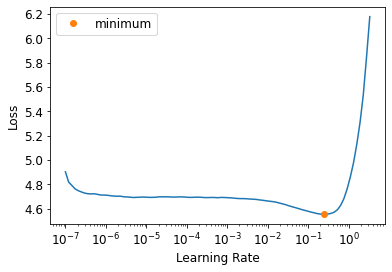

In [19]:
lr_min = learn.lr_find(suggest_funcs=(minimum))
lr_min

In [20]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.646323,3.512013,0.382642,33.515659,2:27:57


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [ ]:
learn.save(file_prefix+'_lm')

Let's now load back the `Learner`

In [9]:
learn = learn.load(file_prefix+'_lm')

Let's validate the `Learner` to make sure we loaded the correct version:

In [10]:
learn.validate()

(#3) [3.5120127201080322,0.38264235854148865,33.51565933227539]

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [13]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [14]:
learn.fit_one_cycle(6, lr_max=2e-3, cbs=SaveModelCallback(fname=file_prefix+'_lm'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.295857,3.214648,0.421965,24.894539,2:35:43
1,3.159792,3.097939,0.438385,22.152239,2:33:45
2,3.083589,3.028106,0.448573,20.658079,2:38:23
3,3.047676,2.976303,0.455922,19.615162,2:33:09
4,3.029696,2.942455,0.460701,18.962334,2:34:27
5,2.967538,2.934300,0.461882,18.808336,2:34:59


Better model found at epoch 0 with valid_loss value: 3.214648485183716.
Better model found at epoch 1 with valid_loss value: 3.0979385375976562.
Better model found at epoch 2 with valid_loss value: 3.028106451034546.
Better model found at epoch 3 with valid_loss value: 2.9763028621673584.
Better model found at epoch 4 with valid_loss value: 2.9424545764923096.
Better model found at epoch 5 with valid_loss value: 2.934300184249878.


Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [15]:
learn.save_encoder(file_prefix+'_lm_finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

### Loading Raw Data

In [6]:
data, data_sample

(Path('/home/deb/xcube/nbs/examples/amazoncat-13k/data/amazoncat-13k.csv'),
 Path('/home/deb/xcube/nbs/examples/amazoncat-13k/data/amazoncat-13k-sample.csv'))

In [7]:
# !head -n 1 {data}

In [8]:
# !shuf -n 200000 {data} > {data_sample} 

In [9]:
df = pd.read_csv(data,
                 header=0,
                 names=['text', 'labels', 'is_valid'],
                 usecols=[1,2,3],
                 dtype={'text': str, 'labels': str, 'is_valid': bool})
len(df)

1493021

In [10]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [11]:
df.head(3)

,text,labels,is_valid
0,"New Englanders on the Ohio Frontier: Migration and Settlement of Worthington, Ohio /SEP/ Virginia E. McCormick served on the faculties of Pennsylvania State University, Iowa State University, and, most recently, Ohio State University. Her previous books include Farm Wife: A Self Portrait, 1886-1896 and Scioto Company Descendants: Genealogies of the Original Proprietors of Worthington, Ohio./i>Robert W. McCormick is professor emeritus and former assistant vice president for continuing education at Ohio State University. He is the author of Cockney: The Story of the 696th Armored Field Art...","38,401,1471,5878,7766,11367,12583",False
1,Le Petit Prince /SEP/ Deluxe Double Disc Musical Spectacular that Comes with a 52 Page Booklet with Libretto and Notes.,"7961,13259",False
2,"Nesco FS-120T American Harvest Food Slicer with Tilt Stand /SEP/ Heavy duty construction plus innovative design equals outstanding product performance. Made from sturdy, heavy duty cast aluminum housing combined with unique ""angle feed"" slicing surface makes slicing easier. Easy to use thickness adjustment and quality, precision crafted Solingen stainless steel cutting blade helps produce perfect cuts. Dual switch safety feature ensures safety during operation. Unit disassembles easily and all removable parts are dishwasher safe, except control panel. 90 watt A/C motor. Gray","4103,5939,6670,10916,11151",False


Sample a small fraction of the dataset to ensure quick iteration:

In [12]:
# df = df.sample(frac=0.1, random_state=89, ignore_index=True)
# len(df)

Let's now gather the labels from the 'labels' columns of the df:

In [13]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(','))

The total number of labels are:

In [14]:
len(lbl_freqs)

13330

Let's take a look at the most common labels:

In [93]:
pd.DataFrame(lbl_freqs.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179
5,96.04,9932
6,96.6,9161
7,584.9,8907
8,250.00,8784
9,96.71,8619


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [15]:
lbls = list(lbl_freqs.keys())

### Dataset Statistics 

#### Check #1: Number of instances (train/valid split)

In [59]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(48991, 15356)

#### Check #2: Avg number of instances per label

In [60]:
array(list(lbl_freqs.values())).mean()

1.4758221491517627

#### Check #3: Plotting the label distribution

In [32]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(',')))

In [85]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [86]:
df_copy.head(2)

,text,labels,is_valid,label_count
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3


The average number of labels per instance is:

In [112]:
df_copy.label_count.mean()

5.385563363865518

/home/deb/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


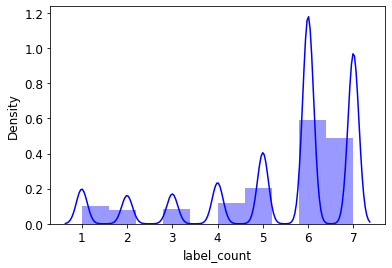

In [87]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [88]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [89]:
lbls_sorted[:20]

[('455619', 2258),
 ('455662', 2176),
 ('547041', 2160),
 ('516790', 1214),
 ('455712', 1203),
 ('455620', 1133),
 ('632786', 1132),
 ('632789', 1132),
 ('632785', 1030),
 ('632788', 1030),
 ('492255', 938),
 ('455014', 872),
 ('670034', 850),
 ('427871', 815),
 ('599701', 803),
 ('308331', 801),
 ('581325', 801),
 ('649272', 799),
 ('455704', 762),
 ('666760', 733)]

In [90]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#670091) ['455619','455662','547041','516790','455712','455620','632786','632789','632785','632788'...],
 (#670091) [2258,2176,2160,1214,1203,1133,1132,1132,1030,1030...])

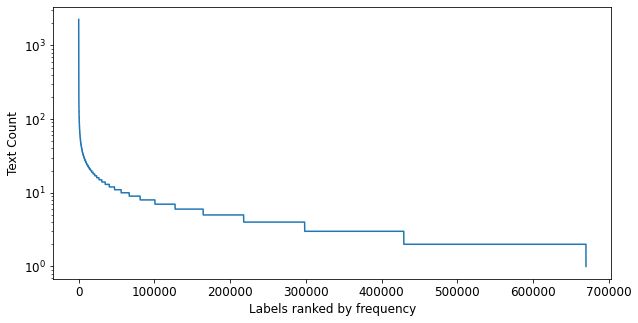

In [91]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Labels ranked by frequency')
ax.set_ylabel('Text Count')
ax.set_yscale('log');

#### Check #4: Computing the min label freq for each text

In [70]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [92]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [93]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [94]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

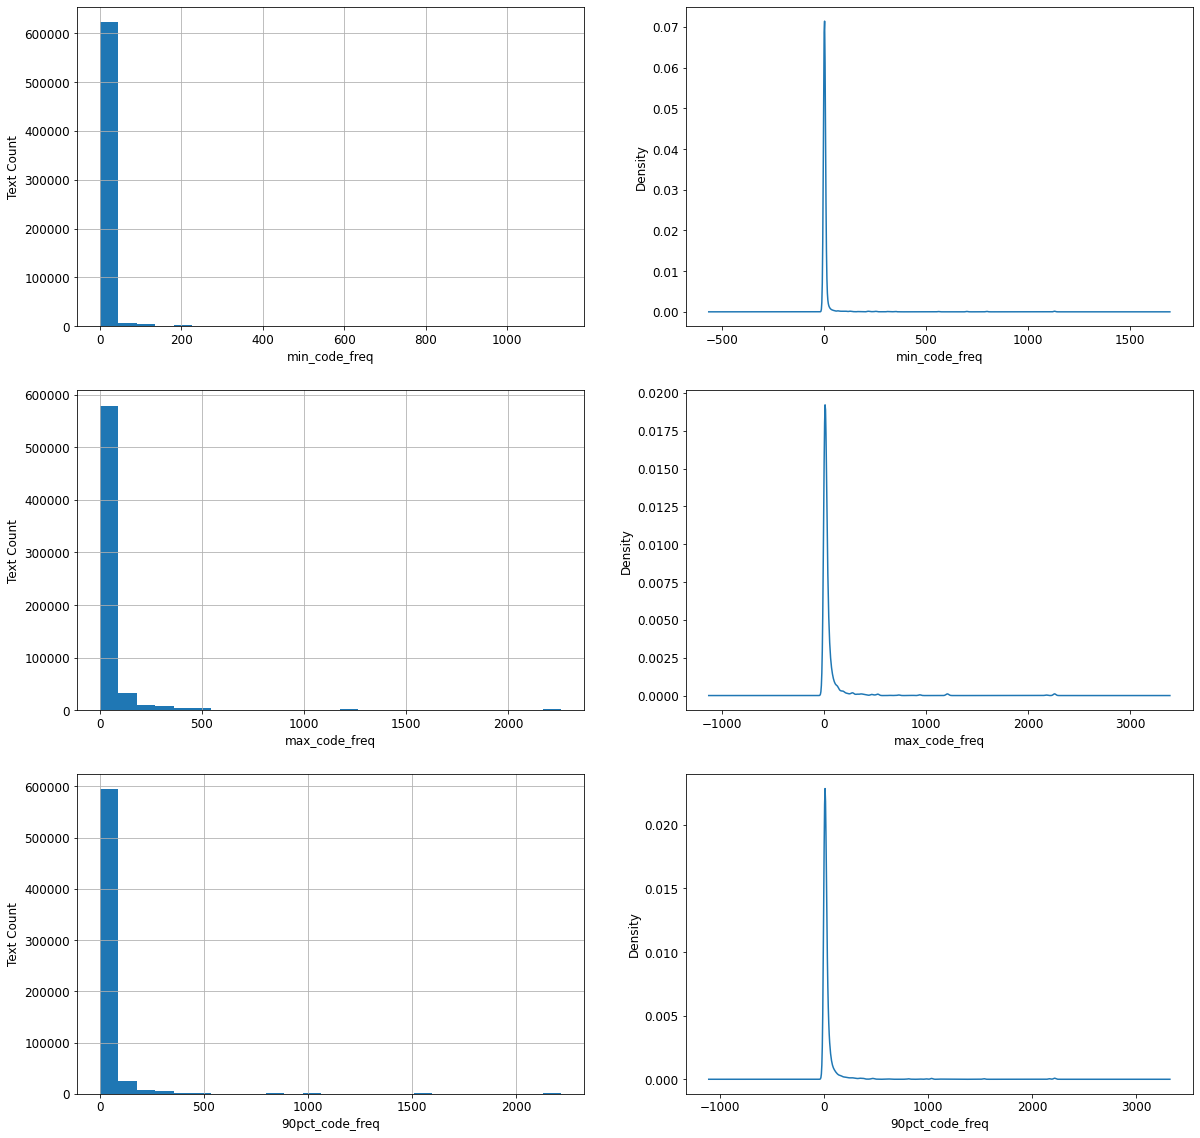

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [96]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [97]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [98]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [99]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

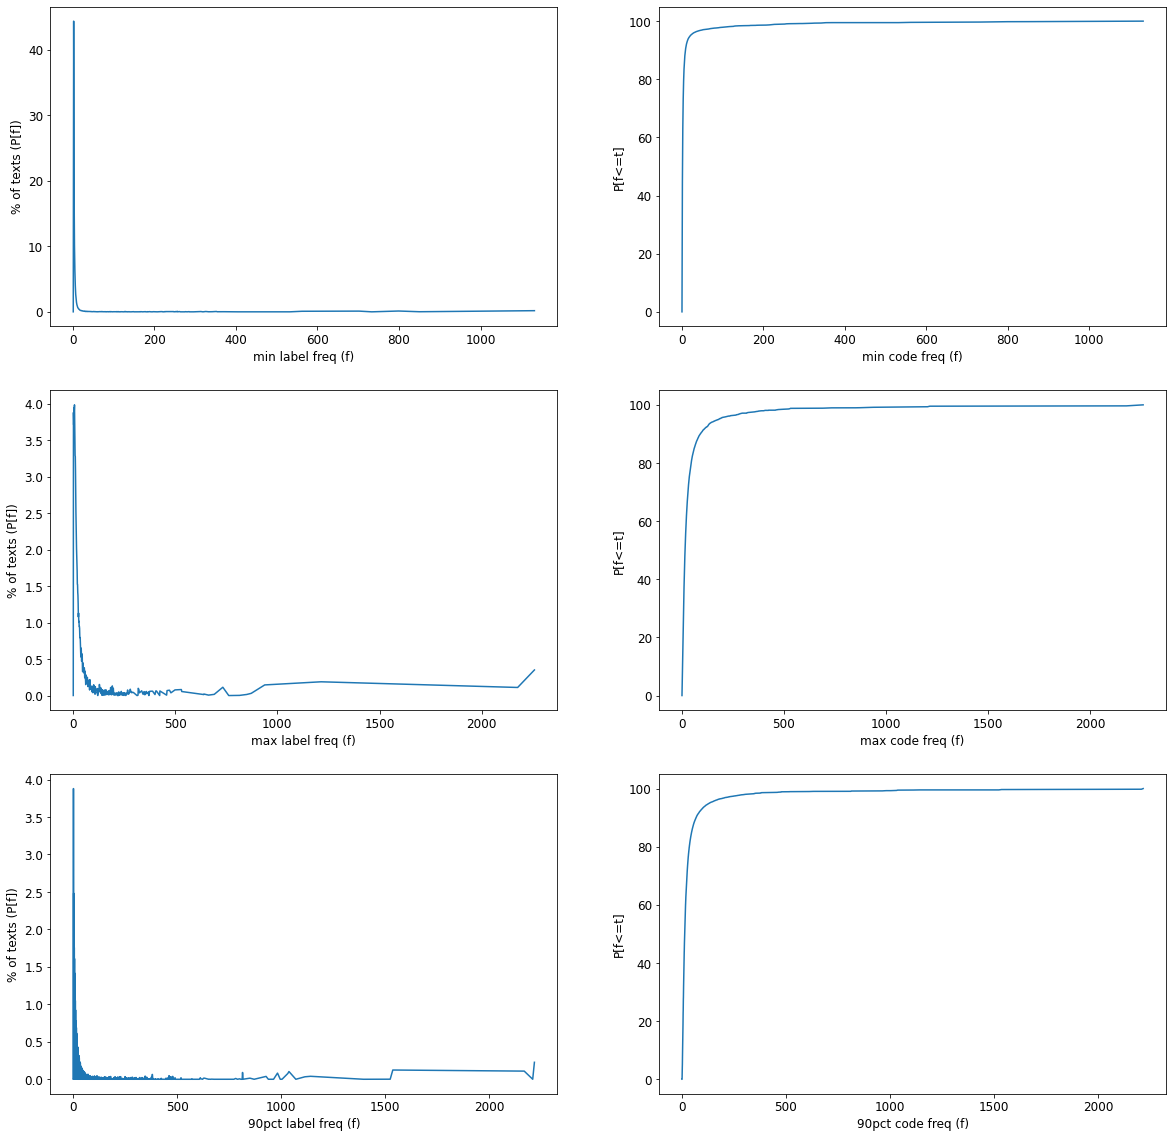

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [16]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [17]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#1186239) [0,1,2,3,4,5,6,7,8,9...],
 (#306782) [1186239,1186240,1186241,1186242,1186243,1186244,1186245,1186246,1186247,1186248...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [18]:
lm_vocab = torch.load(dls_lm_vocab_path)

In [19]:
L(lm_vocab)

(#60008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj',','...]

In [20]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
y_tfms = [ColReader('labels', label_delim=','), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [21]:
dsets = Datasets(df, tfms, splits=splits)

Let's save the `dsets` so that later, depending on the GPU memory available to us, we can create `DataLoaders` with different batch sizes:

In [22]:
torch.save(dsets, dsets_clas_path)

Let's now check if our `Datasets` got created alright:

In [22]:
len(dsets.train), len(dsets.valid)

(1186239, 306782)

In [23]:
x = dsets.train[0]

In [24]:
dsets.decode(x)

("xxbos xxmaj new xxmaj englanders on the xxmaj ohio xxmaj frontier : xxmaj migration and xxmaj settlement of xxmaj worthington , xxmaj ohio / xxup sep / xxmaj virginia xxup e. mccormick served on the faculties of xxmaj pennsylvania xxmaj state xxmaj university , xxmaj iowa xxmaj state xxmaj university , and , most recently , xxmaj ohio xxmaj state xxmaj university . xxmaj her previous books include xxmaj farm xxmaj wife : a xxmaj self xxmaj portrait , 1886 - 1896 and xxmaj xxunk xxmaj company xxmaj descendants : xxmaj genealogies of the xxmaj original xxmaj proprietors of xxmaj worthington , xxmaj ohio . / i > robert xxup w. mccormick is professor emeritus and former assistant vice president for continuing education at xxmaj ohio xxmaj state xxmaj university . xxmaj he is the author of xxmaj cockney : xxmaj the xxmaj story of the xxunk xxmaj armored xxmaj field xxmaj artillery xxmaj battalion in xxmaj world xxmaj war xxunk xxunk are coauthors of xxup a. xxup b. xxmaj graham : xxmaj co

In [25]:
dsets.show(x)

xxbos xxmaj new xxmaj englanders on the xxmaj ohio xxmaj frontier : xxmaj migration and xxmaj settlement of xxmaj worthington , xxmaj ohio / xxup sep / xxmaj virginia xxup e. mccormick served on the faculties of xxmaj pennsylvania xxmaj state xxmaj university , xxmaj iowa xxmaj state xxmaj university , and , most recently , xxmaj ohio xxmaj state xxmaj university . xxmaj her previous books include xxmaj farm xxmaj wife : a xxmaj self xxmaj portrait , 1886 - 1896 and xxmaj xxunk xxmaj company xxmaj descendants : xxmaj genealogies of the xxmaj original xxmaj proprietors of xxmaj worthington , xxmaj ohio . / i > robert xxup w. mccormick is professor emeritus and former assistant vice president for continuing education at xxmaj ohio xxmaj state xxmaj university . xxmaj he is the author of xxmaj cockney : xxmaj the xxmaj story of the xxunk xxmaj armored xxmaj field xxmaj artillery xxmaj battalion in xxmaj world xxmaj war xxunk xxunk are coauthors of xxup a. xxup b. xxmaj graham : xxmaj coun

Looks fine!

#### 3. Making the `DataLoaders` object:

Let's load up the `dsets` created in the previous step:

In [6]:
dsets = torch.load(dsets_clas_path)

We need to pick the sequence length and the batch size:

In [7]:
bs, sl = 32, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [8]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [9]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                        dl_type=dl_type,
                       before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [10]:
torch.save(dls_clas, dls_clas_path)
# torch.save(dls_clas, dls_clas_sample_path)

Let's take a look at the data:

In [11]:
dls_clas.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos xxmaj norton xxmaj anthology of xxmaj poetry / xxup sep / xxmaj the xxmaj ex - queen xxmaj among xxmaj the xxmaj astronomers by xxmaj karen xxmaj fleur xxmaj xxunk xxmaj poem xxmaj ended xxmaj by xxmaj death by xxmaj karen xxmaj fleur xxmaj xxunk xxmaj the xxmaj soho xxmaj hospital xxmaj for xxmaj women by xxmaj karen xxmaj fleur xxmaj xxunk xxmaj xxunk : a xxmaj biography : 2 . xxmaj his xxmaj futile xxmaj preoccupations by xxmaj conrad xxmaj aiken xxmaj the xxmaj xxunk xxmaj xxunk by xxmaj xxunk xxmaj shahid xxmaj ali i xxmaj see xxmaj chile xxmaj in xxmaj my xxmaj rearview xxmaj mirror by xxmaj xxunk xxmaj shahid xxmaj ali i xxmaj see xxmaj chile xxmaj in xxmaj my xxmaj rearview xxmaj mirror by xxmaj xxunk xxmaj shahid xxmaj ali xxmaj the xxmaj arc xxmaj inside xxmaj and xxmaj out ; xxmaj for xxmaj,1471;7083;7081;8108;12630;6093;1648;464;9152;4246
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1471;9202;1274;10994;13199;12444;12445;615;702;11164;7956;12797
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1471;7083;2501;10701;10787


## `Learner` for Multi-Label Classifier Fine-Tuning 

In [6]:
dls_clas = torch.load(dls_clas_path)
# dls_clas = torch.load(dls_clas_sample_path)

In [7]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*20, metrics=partial(PrecisionK, k=5)).to_fp16()

In [9]:
# learn.model[-1]

In [14]:
learn = learn.load_encoder(file_prefix+'_lm_finetuned')

## Fine-Tuning the Classifier 

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

(0.2290867567062378,
 0.010964781977236271,
 0.001737800776027143,
 0.12022644281387329)

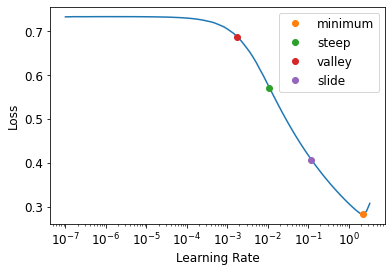

In [15]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [16]:
learn.fit_one_cycle(1, lr_max=lr_min, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,PrecisionK,time
0,0.001156,0.001162,0.541494,4:21:36


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [9]:
learn.freeze_to(-2)

In [ ]:
learn.fit_one_cycle(1, lr_max=0.02, moms=(0.8,0.7,0.8), wd=0.1, 
                    cbs=SaveModelCallback(fname=file_prefix+'_clas'))

Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(fname='clas'))

Finally, we will unfreeze the whole model and perform training:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2,
                   cbs=SaveModelCallback(fname='clas'))

To save the model:

In [17]:
learn.save(file_prefix+'_clas')

Path('models/amazoncat-13k_clas.pth')

To load the model:

In [8]:
learn = learn.load(file_prefix+'_clas')

And, to validate it:

In [10]:
learn.validate()

(#2) [0.0012538068694993854,0.513959749920138]

To plot the train/valid loss and the metric over the course of training:

In [ ]:
learn.recorder.plot_loss()

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));